# Linear Models
## Dream Team - ORIE 4741 Project
### Darren Chang

In [4]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random, Lasso, LassoPlot, LowRankModels
include("proxgrad.jl") 
# using Flux

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278


LoadError: InitError: AssertionError: isfile(__nvdisasm[])
during initialization of module Flux

Load data from CSV.

In [5]:
df = CSV.read("weekly_ff.csv")

feature_names = names(df)
for i in 1:56
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Int64
6	PassingTD			Int64
7	Int			Int64
8	PassingAtt			Int64
9	Cmp			Int64
10	RushingAtt			Int64
11	RushingYds			Int64
12	RushingTD			Int64
13	Rec			Int64
14	Tgt			Int64
15	ReceivingYds			Int64
16	ReceivingTD			Int64
17	FL			Int64
18	PPRFantasyPoints			Float64
19	StandardFantasyPoints			Float64
20	HalfPPRFantasyPoints			Float64
21	type			String
22	game_id			Int64
23	team2			String
24	season			Int64
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_cum			Float64
36	Tgt_cum			Float64
37	ReceivingYds_cum			Float64
38	ReceivingTD_cum			Float64
39	FL_cum			Float64
40	team1_score_cum			Float64
41	team2_score_cum			Float64
42	PassingYds_prev			Int64
43	PassingTD_prev			Int64
44	Int_prev			Int64
45	PassingAt

Train/test split with proportion of training data = 0.8

In [6]:
Random.seed!(0)

df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = target[1:ntrain, :StandardFantasyPoints]
test_std = target[ntrain:end, :StandardFantasyPoints]

train_ppr = target[1:ntrain, :PPRFantasyPoints]
test_ppr = target[ntrain:end, :PPRFantasyPoints]

train_half = target[1:ntrain, :HalfPPRFantasyPoints]
test_half = target[ntrain:end, :HalfPPRFantasyPoints]

# let's take a look
train_x

Size of dataset: 52744


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,13,Daryl Richardson,RB,STL,0,0,0,0
2,13,Bennie Fowler,WR,DEN,0,0,0,0
3,13,Adrian Peterson,RB,MIN,0,0,0,0
4,10,Allen Robinson,WR,JAX,0,0,0,0
5,2,Luke Falk,QB,NYJ,198,0,0,25
6,16,Kendall Hunter,RB,SFO,0,0,0,0
7,3,Preston Parker,WR,TAM,0,0,0,0
8,9,Blake Bortles,QB,JAX,381,2,2,40
9,12,Randall Cobb,WR,GNB,0,0,0,0


Convert string data to float and to integer (Julia thinks that game_id and season are string, although both can be expressed as integers/floats).

In [7]:
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

string_to_float (generic function with 1 method)

In [8]:
function string_to_int(str)
    try
        parse(Int64, str)
    catch
        0
    end
end

string_to_int (generic function with 1 method)

In [9]:
train_x[:game_id] = string_to_float.(train_x[:game_id])
test_x[:game_id] = string_to_float.(test_x[:game_id])

10550-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [10]:
train_x[:season] = string_to_int.(train_x[:season])
test_x[:season] = string_to_int.(test_x[:season])

10550-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

Create a real-valued subset.

In [11]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev 
]

train_real = train_x[labels_real]
test_real = test_x[labels_real]

,PassingYds_cum,PassingTD_cum,Int_cum,PassingAtt_cum,Cmp_cum,RushingAtt_cum
,Float64,Float64,Float64,Float64,Float64,Float64
1,224.375,1.125,0.5,35.75,21.125,6.125
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,13.0
4,0.0,0.0,0.0,0.0,0.0,14.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,3.0
8,0.0,0.0,0.0,0.0,0.0,4.3
9,267.5,2.0,0.5,37.5,24.0,3.0


Convert the categorical labels into one-hot encoded data. This is for the team of the player (team1) and the team of the opponent (team2) as well as the position. 

In [12]:
df[:team1]

52744-element Array{String,1}:
 "STL"
 "DEN"
 "MIN"
 "JAX"
 "NYJ"
 "SFO"
 "TAM"
 "JAX"
 "GNB"
 "MIA"
 "CHI"
 "BUF"
 "SFO"
 ⋮
 "DET"
 "CIN"
 "PIT"
 "GNB"
 "TEN"
 "HOU"
 "MIN"
 "MIA"
 "SEA"
 "CIN"
 "DET"
 "NOR"

In [13]:
cats_sets

LoadError: UndefVarError: cats_sets not defined

In [14]:
cats_sets = unique(df[:, :team1])
# Flux.onehotbatch(df[:team1], cats_sets)

LoadError: UndefVarError: Flux not defined

In [15]:
cat_labels = [
  :team1,
  :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)

10550×158 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [16]:
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0)
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0)

10550×189 Array{Float64,2}:
 224.375  1.125  0.5   35.75       …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 267.5    2.0    0.5   37.5           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 220.75   1.75   0.75  32.5           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   0.0    0.0    0.0    0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
   ⋮                               ⋱

In [17]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

In [18]:
"""This completed function plots the main diagonal
for a predicted vs true plot with perfect predictions
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This completed helper function plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (Projected Points)", "True (Actual Points)", zeromin=true)
end

plot_pred_true

In [19]:
w = Xtrain \ train_std
train_pred = sum(w'.*Xtrain, dims = 2)
test_pred = sum(w'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

20.225293319610067

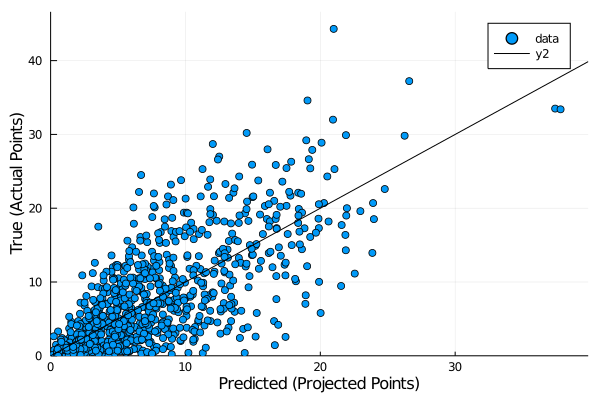

In [20]:
plot_pred_true(test_pred, test_std)

## GLM and Lasso Packages
Use packages for lasso regression and for different loss functions with the data loaded from the csv.

In [27]:
Xtrain_glm = replace(hcat(convert(Matrix, train_real), train_cat_vals), NaN=>0)

42195×188 Array{Float64,2}:
   0.0    0.0      0.0       0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 198.0    0.0      0.0      25.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 274.125  2.125    1.25     38.875         0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 218.267  1.53333  1.06667  28.8        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  

In [46]:
m = lm(Xtrain_glm[:, 1:97], train_std) # works with 97 variables

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────────────
            Coef.  Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────
x1    0.0448619    0.00294917   15.21    <1e-51   0.0390815    0.0506423
x2    4.80636      0.148916     32.28    <1e-99   4.51448      5.09823
x3   -2.40251      0.146914    -16.35    <1e-59  -2.69047     -2.11456
x4   -0.0141605    0.0293266    -0.48    0.6292  -0.0716412    0.0433202
x5   -0.011772     0.0499229    -0.24    0.8136  -0.109622     0.086078
x6   -0.169677     0.0193966    -8.75    <1e-17  -0.207695    -0.13166
x7    0.138031     0.00417216   33.08    <1e-99   0.129853     0.146208
x8    7.38892      0.167181     44.20    <1e-99   7.06124      7.7166
x9    0.0294574    0.0513746     0.57    0.5664  -0.0712378    0.130153
x10  -0.16286

In [51]:
lm(Xtrain_glm[:, 1:98], train_std) # doesn't work with 98 features because of multicollinearity

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

Use $\texttt{allowrankdeficient = true}$ to analytically solve some of the issues with multicollinearity.

In [52]:
m_2 = lm(Xtrain_glm, train_std, true)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,CholeskyPivoted{Float64,Array{Float64,2}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────────────────
            Coef.    Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────
x1     0.0449176     0.0029501    15.23    <1e-51    0.0391353     0.0506998
x2     4.80255       0.149015     32.23    <1e-99    4.51048       5.09462
x3    -2.45474       0.147195    -16.68    <1e-61   -2.74325      -2.16624
x4    -0.0580173     0.0302686    -1.92    0.0553   -0.117344      0.00130982
x5     0.01319       0.0501344     0.26    0.7925   -0.0850745     0.111455
x6    -0.189716      0.020437     -9.28    <1e-19   -0.229773     -0.149659
x7     0.139441      0.00419163   33.27    <1e-99    0.131225      0.147657
x8     7.42001       0.168037     44.16    <1e-99    7.09065       7.74937
x9     0.0553478     0.0530618 

Generic OLS with the first matrix (that has 198 rows) shows that some columns may be multicollinear, so we should consider how to resolve this multicollinearity. We can create a new matrix that takes out the multicollinear columns.

In [63]:
Xtrain_glm2 = hcat(Xtrain_glm[:,1:93], Xtrain_glm[:, 95:128], Xtrain_glm[:, 130:184])

42195×182 Array{Float64,2}:
   0.0    0.0      0.0       0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 198.0    0.0      0.0      25.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 274.125  2.125    1.25     38.875         0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 218.267  1.53333  1.06667  28.8        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  

That allows us to calculate OLS with the typical algorithm.

In [64]:
m3 = lm(Xtrain_glm2, train_std)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────────────
            Coef.  Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────
x1     0.0449176   0.0029501    15.23    <1e-51    0.0391353    0.0506998
x2     4.80255     0.149015     32.23    <1e-99    4.51048      5.09462
x3    -2.45474     0.147195    -16.68    <1e-61   -2.74325     -2.16624
x4    -0.0580173   0.0302686    -1.92    0.0553   -0.117344     0.00130982
x5     0.01319     0.0501344     0.26    0.7925   -0.0850745    0.111455
x6    -0.189716    0.020437     -9.28    <1e-19   -0.229773    -0.149659
x7     0.139441    0.00419163   33.27    <1e-99    0.131225     0.147657
x8     7.42001     0.168037     44.16    <1e-99    7.09065      7.74937
x9     0.0553478   0.0530618     1.04    0.2969   -0.0486544    0.15935

In [68]:
pred_m3 = predict(m3, Xtrain_glm2)

42195-element Array{Float64,1}:
  5.077833661575909
  3.8234172724471973
 14.910318767651745
 12.56687913380861
  8.980745540093785
  4.966786440716526
  3.8049059809443246
 19.53249384642361
  3.359892382737505
  2.7456877089933522
 11.557036990254458
  1.9670129702554295
  6.94252548969412
  ⋮
  6.4665087604635065
  3.1334586524363033
  2.671008584803469
  1.600548909575429
  3.328711697449937
  3.3857309413690793
  6.330911271287089
  0.9576170253019066
  6.946895168455128
 12.603986431618143
  3.7586725440724837
 16.58120862668441

In [69]:
Xtest_glm = replace(hcat(convert(Matrix, test_real), test_cat_vals), NaN=>0)
Xtest_glm2 = hcat(Xtest_glm[:,1:93], Xtest_glm[:, 95:128], Xtest_glm[:, 130:184])
pred_m3_test = predict(m3, Xtest_glm2)
test_MSE = MSE(test_std, pred_m3_test)

20.225452341021185

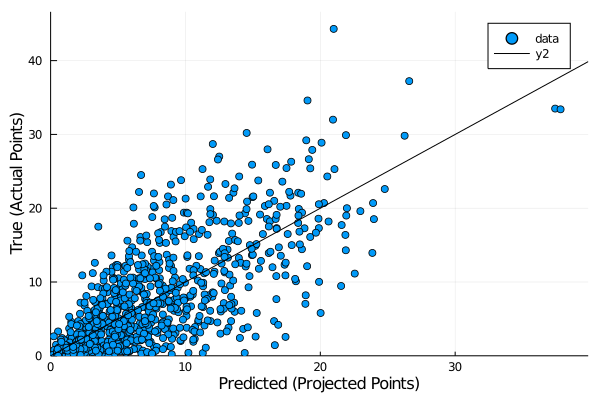

In [84]:
plot_pred_true(pred_m3_test, test_std)
# savefig("ols.png")

In [66]:
m_lasso = fit(LassoPath, Xtrain_glm2, train_std, Normal())

LassoPath (86) solutions for 183 predictors in 3176 iterations):
───────────────────────────────────
               λ    pct_dev  ncoefs
───────────────────────────────────
 [1]  3.20194     0.0             0
 [2]  2.91749     0.0360114       1
 [3]  2.65831     0.0659086       1
 [4]  2.42215     0.0907299       1
 [5]  2.20697     0.123504        2
 [6]  2.01091     0.156755        2
 [7]  1.83227     0.198836        4
 [8]  1.66949     0.250555        5
 [9]  1.52118     0.303153        5
[10]  1.38604     0.348086        6
[11]  1.26291     0.385636        6
[12]  1.15072     0.416783        6
[13]  1.04849     0.442643        6
[14]  0.955346    0.464084        6
[15]  0.870476    0.481916        6
[16]  0.793145    0.496713        6
[17]  0.722684    0.509019        6
[18]  0.658483    0.519201        6
[19]  0.599985    0.52767         6
[20]  0.546684    0.534713        6
[21]  0.498118    0.540537        6
[22]  0.453867    0.545396        6
[23]  0.413546    0.549418        6

In [100]:
pred_m_lasso_test = predict(m_lasso, Xtest_glm2)[:, 86]
test_MSE_lasso = MSE(test_std, pred_m_lasso_test)

20.219893254486667

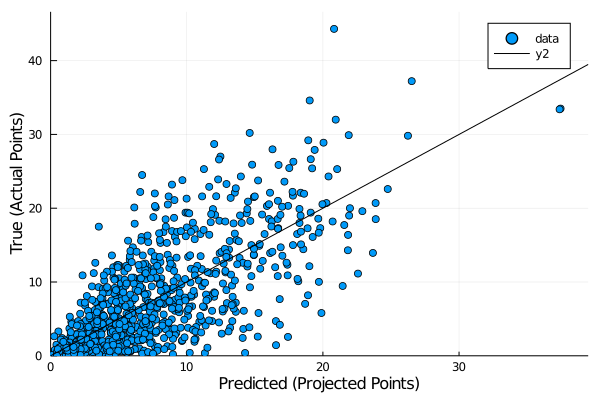

In [86]:
plot_pred_true(pred_m_lasso_test, test_std)
# savefig("lasso.png")

┌ Warning: You created n=118 groups... Is that intended?
└ @ RecipesPipeline C:\Users\darre\.julia\packages\RecipesPipeline\tkFmN\src\group.jl:14


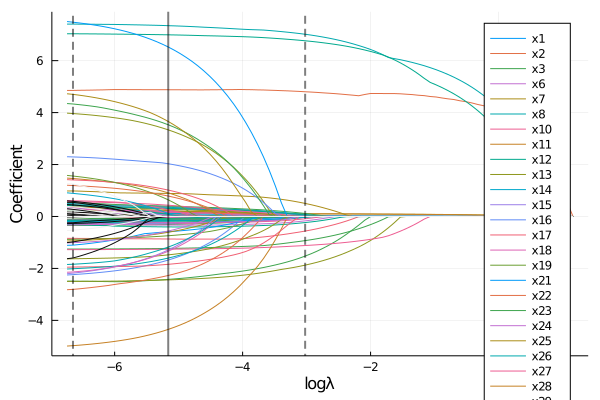

In [97]:
plot(m_lasso; x=:logλ)

## Quantile Regression

In [145]:
# loss function
α = 0
loss = QuantileLoss(α)
k = 5

# regularization function
λ = 0.1
reg = QuadReg(λ)
Ω = train_std
Y = Xtrain_glm2;

In [147]:
glrm_quant = GLRM(Y, loss, reg, reg, k)

GLRM([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 224.375 1.125 … 0.0 0.0], Loss[QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5)  …  QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5), QuantileLoss(0.0, RealDomain(), 0.5)], Regularizer[QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), QuadReg(0.1), 

In [149]:
X,W,ch = fit!(glrm_quant)

Fitting GLRM
Iteration 10: objective value = 87.87397183330319


([-0.9975261724052704 0.9034413164799847 … -0.4448290925495725 -0.5877803889598407; 1.0881735089935733 0.10170058702867431 … -1.3529192186387489 -2.069635549791297; … ; 1.0579370739163911 0.3622482064685896 … 0.665881150290037 0.11426332799573899; 0.6978193369272861 1.0386636905324844 … -0.05633315953838893 0.4808879679028684], [-0.5102000380787496 2.1374288204566287 … -1.698387633087913 -1.7197237139549637; 0.12679818067466078 -0.2266659248892301 … -0.812079897815756 -0.5950026124239434; … ; 0.7114031891557702 -1.293764663667348 … -0.06000178909519252 0.04345559628868198; -1.0071927062540684 2.5248220427203116 … -0.6348510388198132 1.8155560765811303], ConvergenceHistory("ProxGradGLRM", [21211.999465907218, 87.88361680519442, 87.88274205774175, 87.88182358240142, 87.88085919375108, 87.87984659719697, 87.87878338352549, 87.87766702318334, 87.87649486027314, 87.87526410624979, 87.87397183330319, 87.8726149674116], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

In [150]:
X,W,ch = fit!(glrm_quant) # having trouble with this one

Fitting GLRM
Iteration 10: objective value = 87.862138305542


([-0.9821686642566952 0.8895323005930671 … -0.437980684354847 -0.5787311606160294; 1.0714204312360875 0.10013484606145566 … -1.3320902233708762 -2.0377722807365504; … ; 1.0416495040432372 0.35667118008417514 … 0.6556295143185178 0.11250417616662292; 0.6870759935949968 1.0226728458486607 … -0.05546587707445143 0.47348441189609963], [-0.5101656839380377 2.137284897436286 … -1.6982732727520138 -1.7196079169615388; 0.1267896427636145 -0.2266506624186361 … -0.8120252167005136 -0.5949625481316158; … ; 0.7113552870714128 -1.2936775484772531 … -0.059997748895757604 0.043452670221339376; -1.0071248872862673 2.524652034713149 … -0.6348082913476631 1.8154338267491619], ConvergenceHistory("ProxGradGLRM", [20566.557954976797, 87.87178197859537, 87.87090734894035, 87.86998899728627, 87.86902473850509, 87.86801227831205, 87.86694920781801, 87.86583299781029, 87.8646609927491, 87.86343040446496, 87.862138305542, 87.86078162237244], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## proxgrad.jl method

In [171]:
# loss function
loss = QuantileLoss(0.01)

# regularization function
reg = QuadReg(0.1)
b = proxgrad(loss, reg, Xtrain_glm2, train_std, maxiters = 10, stepsize=.01)

norm(Xtrain_glm2*b-train_std) / norm(train_std)

0.5564404091078012